In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab0.ipynb")

# Lab 0:  Review and warm-up
Welcome to the first Data 102 lab! 

The goal of this lab is to review some basic probability and programming. We will also learn more about binary decision making.

The code (and answers) that you need to write is commented out with a message **"TODO: ..."**. There is additional documentation for each part as you go along.


## Collaboration Policy
Data science is a collaborative activity. While you may talk with others about the labs, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the cell below.

## Submission
To submit this assignment, rerun the notebook from scratch (by selecting Kernel > Restart & Run all), and then print as a pdf (File > download as > pdf) and submit it to Gradescope.

**For full credit, this assignment should be completed and submitted before Wednesday, January 25, 2023 at 11:59 PM PST.**

## Collaborators
Write the names of your collaborators in this cell.

`<Collaborator Name> <Collaborator e-mail>`

# Setup
Let's begin by importing the libraries we will use. You can find the documentation for the libraries here:
* matplotlib: https://matplotlib.org/3.1.1/contents.html
* numpy: https://docs.scipy.org/doc/
* pandas: https://pandas.pydata.org/pandas-docs/stable/
* seaborn: https://seaborn.pydata.org/

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

import timeit
import hashlib
%matplotlib inline

sns.set(style="dark")
plt.style.use("ggplot")

# Question 0: Vectorized operations in NumPy

We'll start this lab by reviewing the concept of **vectorization**. Many of the functions in NumPy (and pandas) are optimized to be much faster than the equivalent code using a `for` loop. This is because NumPy uses optimized and pre-compiled code written in a low-level language (in this case, C) to carry out mathematical operations. By using NumPy's vectorized operations instead of iterating explicitly (e.g., writing `for` loops), we can make our code run much faster. In some cases, this difference is small, but you'll see in future labs and homework assignments that sometimes it has a big impact.

Let's see vectorization in action and measure the time it takes to perform some vectorized and non-vectorized tasks on NumPy arrays. We'll start by summing numbers from 0 to 14,999. 

In [3]:
%%timeit

sum_nonvect = 0
for item in range(0, 15000):
     sum_nonvect += item

433 µs ± 2.48 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [4]:
%%timeit

sum_vect = np.sum(np.arange(15000))

16.5 µs ± 164 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


<!-- BEGIN QUESTION -->

### a) How much faster is the vectorized version? Your answer should be a multiplicative factor (e.g., "it takes half as long").

Vectorized version is almost 26 times faster than the for-loop version.

<!-- END QUESTION -->


Now, consider the following array:

In [5]:
arr = np.random.random([2000, 2000])
arr

array([[0.27847837, 0.90953443, 0.32512283, ..., 0.55795342, 0.58546928,
        0.43239737],
       [0.70165962, 0.18232978, 0.39377851, ..., 0.0440615 , 0.43472232,
        0.82814834],
       [0.75079135, 0.00734291, 0.027332  , ..., 0.91779081, 0.38321526,
        0.92037836],
       ...,
       [0.55339376, 0.78340458, 0.3425424 , ..., 0.22807523, 0.84988305,
        0.44631139],
       [0.87351043, 0.34027198, 0.54935033, ..., 0.28832037, 0.43275555,
        0.83418258],
       [0.79144435, 0.76845907, 0.30222465, ..., 0.75694144, 0.45914242,
        0.96393374]])

Suppose we want to compute a new array where each entry is the average of two neighboring entries in the original array. So, the first row would look like `[1.5, 4.5, 7.5, 10.5]` (we'll see examples of operations like this later in the class). Let's try doing this two different ways:

In [6]:
%%timeit
# Using nested for loops

new_array_slow = np.zeros([arr.shape[0], arr.shape[1] - 1])
for i in range(arr.shape[0]):
    for j in range (arr.shape[1] - 1):
        new_array_slow[i,j] = (arr[i,j] + arr[i, j+1])/2
new_array_slow

1.82 s ± 12.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%%timeit

new_array_fast = (arr[:, :-1] + arr[:, 1:])/2

9.01 ms ± 125 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<!-- BEGIN QUESTION -->

### b) Suppose your friend looks at this and says that while the vectorized version does run faster, both versions run fast enough that it doesn't matter. Give two reasons your friend might be wrong.

*Hint: What happens if an algorithm needs to run this kind of operation many times?*

*Hint: try replacing `arr` with `np.random.random([2000, 2000])`. How do the results change?*

1. A few small arrays might not matter, but doing it with large amount of small arrays will make a big difference.
2. The bigger the size of the array is, the longer it will take. For example, np.random.random([2000, 2000]) vectorized verison is 20 times faster than for loop version.

<!-- END QUESTION -->

# Question 1: The sinking of the Titanic
On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew. 

In this question we will work with data about passengers traveling on the Titanic, and we will try to understand whether some groups of people were more likely to survive than others. We will also fit a binary classifier to the data and check its performance (e.g. how many false positive does it produce?) 

Let's start by importing the Titanic dataset using Pandas.

In [8]:
titanic = pd.read_csv("titanic.csv")
titanic.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


Here is a brief description of the variables included in the dataframe:
* **Survived**: binary variable taking value 1 if the person survived the shipwreck, 0 otherwise;
* **Pclass**: whether the passenger was traveling in 1st, 2nd, or 3rd class; 
* **Name**: passenger's name;
* **Sex**: passenger's gender;
* **Age**: passenger's age;
* **Siblings/Spouses Aboard**: how many siblings or spouses the passenger is traveling with;
* **Parents/Children Aboard**: how many parents or children the passenger is traveling with;
* **Fare**: what was the fare that the passenger paid.

<!-- BEGIN QUESTION -->

## Part 1.a: Dataset check
We will first check some general properties of the dataframe. For example, we will see how many rows and columns the dataframe has and if there are missing values.

In [9]:
# TODO: find the number of rows and columns in the dataframe 
print("rows:", titanic.shape[0])
print("columns:", titanic.shape[1])

rows: 887
columns: 8


In [10]:
# TODO: check how many missing values there are per column
titanic.isna().sum()

Survived                   0
Pclass                     0
Name                       0
Sex                        0
Age                        0
Siblings/Spouses Aboard    0
Parents/Children Aboard    0
Fare                       0
dtype: int64

<!-- END QUESTION -->

Running the cell below, we can also check how many different values each variable takes.

In [11]:
titanic.nunique()

Survived                     2
Pclass                       3
Name                       887
Sex                          2
Age                         89
Siblings/Spouses Aboard      7
Parents/Children Aboard      7
Fare                       248
dtype: int64

## Part 1.b: Exploring the dataset
We'll now look into more detail at some descriptive statistics and plots. We would like to know the percentage of people who survived the shipwreck and the passengers' distribution in terms of sex, age, class, etc.

For a refresher on data visualization using pandas and seaborn, you can refer to [Chapter 11 of the Data 100 textbook](https://www.textbook.ds100.org/ch/11/viz_intro.html).

Let's start by computing the percentage of people in the dataset who survived the shipwreck.

In [12]:
# TODO: compute the percentage of people who survived (expressed as a decimal between 0 and 1)
survival_prob = titanic['Survived'].value_counts().iloc[1] / titanic.shape[0]
survival_prob

0.3855693348365276

In [13]:
grader.check("q1b_i")

q1b_i results: All test cases passed!

The cell below uses the `countplot` function from seaborn to generate a plot displaying how many passengers were traveling in each of the three classes.

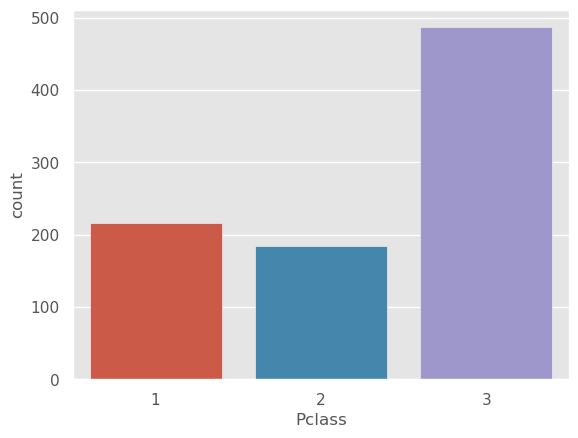

In [14]:
sns.countplot(x = titanic["Pclass"]);

We can see that the distribution is not uniform and that the majority of the passengers were traveling in third class. 

In the next question, write a line of code to generate a bar graph for the distribution of passenger sex.

<!-- BEGIN QUESTION -->



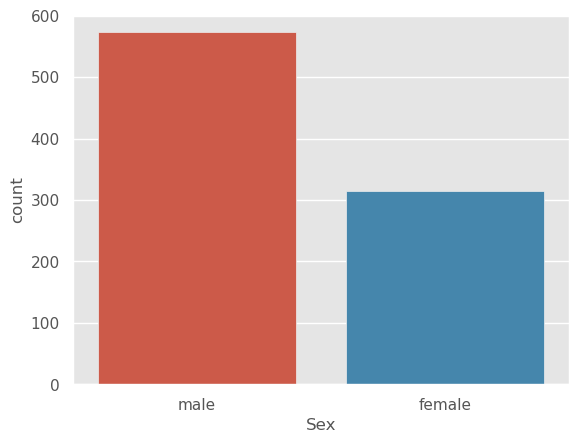

In [15]:
# TODO: use countplot to show how the distribution of passenger sex
sns.countplot(x = titanic["Sex"]);

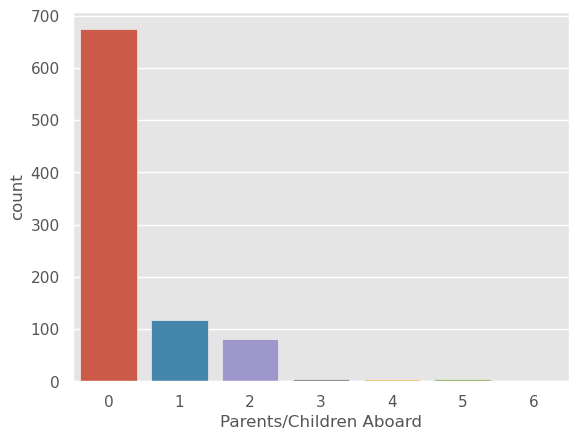

In [16]:
# TODO: use countplot to show the distribution of the number of parents/children aboard
sns.countplot(x = titanic["Parents/Children Aboard"]);

Summing up: there were nearly twice as many male passengers as female passengers, and the majority of people were traveling without parents or children.

Let's conclude by looking at the distribution of age and fare paid. In the next cell, write a line of code to visualize the distribution of passenger ages. *Hint: since the age column contains numerical data, you shouldn't use `sns.countplot`, which is meant for categorical data. Is there another seaborn function you can use?*

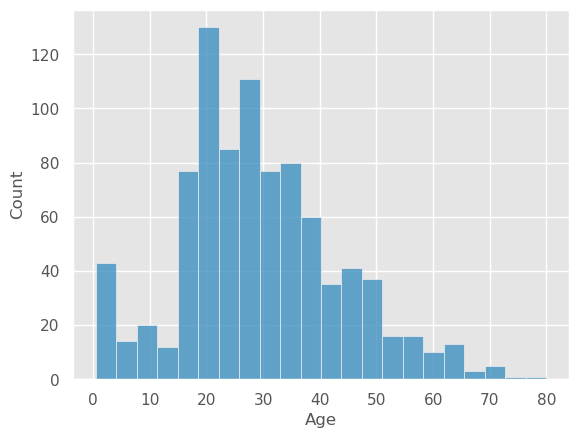

In [17]:
# TODO: visualize the distribution of passenger ages
sns.histplot(titanic["Age"]);

<!-- END QUESTION -->

You should see that most travelers were in their 20s and 30s, and there were also many babies. What is the age of the youngest passenger? And the oldest?

In [18]:
min(titanic["Age"]) 

0.42

In [19]:
# TODO: print the age of the oldest passenger
max_age = max(titanic["Age"])
max_age

80.0

In [20]:
grader.check("q1b_iii")

q1b_iii results: All test cases passed!

<!-- BEGIN QUESTION -->



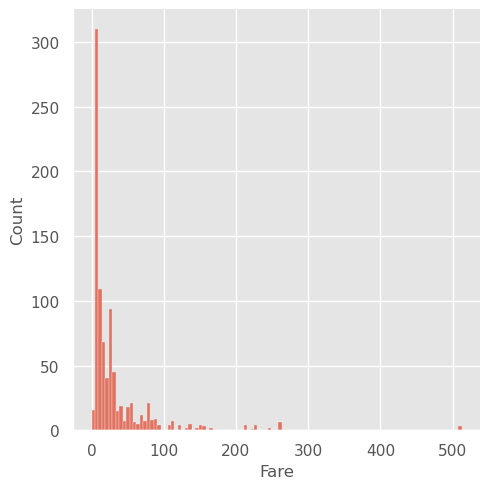

In [21]:
# TODO: use displot to show the fare distribution
sns.displot(titanic["Fare"]);

The fare distribution is really skewed: most people spent very little, but there is someone who spent even more than 500! Who are these people?

In [22]:
# TODO: display the rows corresponding to passengers who spent more than 500.
titanic[titanic["Fare"] > 500]

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
257,1,1,Miss. Anna Ward,female,35.0,0,0,512.3292
676,1,1,Mr. Thomas Drake Martinez Cardeza,male,36.0,0,1,512.3292
733,1,1,Mr. Gustave J Lesurer,male,35.0,0,0,512.3292


<!-- END QUESTION -->

## Part 1.c: Conditional probabilites

So far, we have looked at the variables separately, considering each marginal distribution. This tells us about them individually, but we're also interested in the relationships between variables. In particular, we want to find connections between survival and the other variables. For example, we might wonder whether people in first class had a higher probability of surviving than people in third class, or if females survived more or less often than males. To answer this type of question, we'll need to look at **conditional probabilities**. For a refresher on conditional probabilities, you can refer to [Section 4.4 of the Data 140 textbook](http://prob140.org/textbook/content/Chapter_04/04_Conditional_Distributions.html).

Let's start by looking at the conditional probabilities of survival given class type. If we denote the survival variable by $S$ and the class variable by $C$, we are comparing:

$$\mathbb{P}(S = 1 | C = 1) \quad \text{ vs } \quad \mathbb{P}(S = 1 | C = 2) \quad \text{ vs }\quad \mathbb{P}(S = 1 | C = 3)$$

We'll first compute $\mathbb{P}(S = 1 | C = 1)$, the probability of surviving given that the passenger has a first-class ticket. To do so, remember the definition of conditional probability: for two events $A$ and $B$,

$$
P(A|B) = \frac{P(A \text{ and } B)}{P(B)}
$$

In this case, we don't have to use Bayes' rule since we can compute the conditional probably directly using the definition.

In [23]:
# TODO: complete the following code to compute P(S=1|C=1)
firstclass_survival_prob = np.mean((titanic["Survived"] == 1) \
    & (titanic["Pclass"] == 1)) / np.mean(titanic["Pclass"] == 1)
firstclass_survival_prob

0.6296296296296297

So, almost 63% of passengers traveling in first class survived: not bad! 

What about people in the other two classes?

In [24]:
# TODO: compute the conditional probability of survival given that the passenger is in class 2
secondclass_survival_prob = np.mean((titanic["Survived"] == 1) \
    & (titanic["Pclass"] == 2)) / np.mean(titanic["Pclass"] == 2)
secondclass_survival_prob

0.47282608695652173

In [25]:
# TODO: compute the conditional probability of survival given that the passenger is in class 3
thirdclass_survival_prob = np.mean((titanic["Survived"] == 1) \
    & (titanic["Pclass"] == 3)) / np.mean(titanic["Pclass"] == 3)
thirdclass_survival_prob

0.24435318275154008

In [26]:
grader.check("q1c")

q1c results: All test cases passed!

Survival probabilities were very different for the three class types! High class passenger had higher chances to survive.

We can also visualize survivals by class running the following cell.

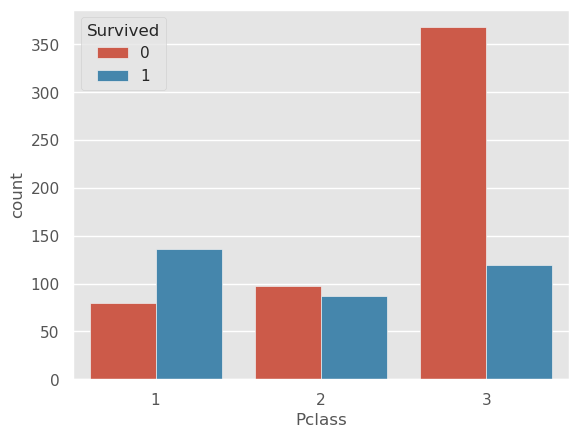

In [27]:
sns.countplot(x = 'Pclass', hue = "Survived", data = titanic);

You can keep on exploring and play with the other variables too, checking if there are groups with high or low probability of surviving. Try to condition on more than one variable (e.g. condition on both class type and gender).

## Part 1.d: Binary classification

In this last part, we're going to use logistic regression to predict passenger survival from the other variables. Here are the steps we'll follow:

1. Split the dataset into a training and test set
2. Fit a logistic regression model to the training set
3. Evaluate the performance on the test set using the language of binary decision-making that you saw in last week's lecture

We've done most of steps 1 and 2 for you, but we **strongly** encourage you to read through and understand all the code, since you'll need to do it yourself in future labs and homework assignments. Some resources that might be helpful:

* [Data 100 textbook: logistic regression](https://learningds.org/ch/19/classification_log_model.html)
* [Data 100 textbook: one-hot encoding](https://learningds.org/ch/15/linear_categorical.html)
* scikit-learn's documentation for `LabelEncoder` and `train_test_split` (you'll have to find these on your own).


Running the following cell will prepare the data and split it into training and test sets.

In [28]:
titanic["Sex"] = LabelEncoder().fit_transform(titanic["Sex"]) # encode gender variable (from string to integer)
titanic = titanic.drop("Name", axis = 1) # drop Name column

X = titanic.drop("Survived", axis = 1) # independent variables
y = titanic["Survived"] # dependent variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 3)

Now, we are ready to fit our logistic regression classifier and to predict which passengers in the test data survived.

In [29]:
lr = LogisticRegression(random_state = 0)
lr.fit(X_train, y_train) # fit the classifier to the training data
yhat = lr.predict(X_test) # predict survival for test data

Complete the code in the following cell to generate a new dataframe with two columns: the first containing our **decisions** and the second containing the values in **reality**.

In [30]:
output = pd.DataFrame()
output["Decisions"] = yhat
output["Reality"] = y_test.values
output

,Decisions,Reality
0,0,0
1,0,0
2,0,0
3,0,1
4,0,0
...,...,...
262,0,0
263,1,1
264,1,1
265,0,0


In [31]:
grader.check("q1d_i")

q1d_i results: All test cases passed!

We're now interested in evaluating the performance of the logistic regression classifier: let's check how many false positive, false negative, true positive and true negative we have obtained.

In [32]:
# TODO: compute the number of false positives (FP), false negatives (FN), true positives (TP), and true negatives (TN)
FP = output.loc[ (output['Decisions'] == 1) & (output['Reality'] == 0) ].shape[0]
FN = output.loc[ (output['Decisions'] == 0) & (output['Reality'] == 1) ].shape[0]
TP = output.loc[ (output['Decisions'] == 1) & (output['Reality'] == 1) ].shape[0]
TN = output.loc[ (output['Decisions'] == 0) & (output['Reality'] == 0) ].shape[0]
print("TP:", TP, "TN:", TN, "FP:", FP, "FN:", FN)

TP: 74 TN: 138 FP: 23 FN: 32


In [33]:
grader.check("q1d_ii")

q1d_ii results: All test cases passed!

<!-- BEGIN QUESTION -->

Using the four numbers you found above, answer the two multiple choice questions below. *Hint: It might help to draw out the 2-by-2 table as in lecture.*

In which of the following two settings did the classifier perform better?

(a) People who actually survived

(b) People who actually did not survive

In which of the following two settings did the classifier perform better?

(a) People for whom the classifier predicted they survived

(b) People for whom the classifier predicted they did not survive

(b) People who actually did not survive

(b) People for whom the classifier predicted they did not survive


<!-- END QUESTION -->

## Congrats! You've reached the end of the lab!
Before you submit to gradescope, make sure that you pass all the autograded portions of this lab.

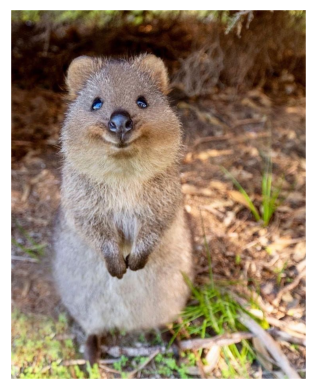

Congrats! You made it to the end of the lab!!!


In [34]:
import matplotlib.image as mpimg
img = mpimg.imread('cute_quokka.jpg')
imgplot = plt.imshow(img)
imgplot.axes.get_xaxis().set_visible(False)
imgplot.axes.get_yaxis().set_visible(False)
plt.show()
print('Congrats! You made it to the end of the lab!!!')

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [35]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

Running your submission against local test cases...



Your submission received the following results when run against available test cases:

    q1b_i results: All test cases passed!

    q1b_iii results: All test cases passed!

    q1c results: All test cases passed!

    q1d_i results: All test cases passed!

    q1d_ii results: All test cases passed!
